## 复现内容：
### （1）python 实现基于贝叶斯的 IMDB 文本情感分类算法。(√)
### （2）掌握文本类数据特征处理方式。(√)
### （3）掌握 TF_IDF 的基本思想，并使用 TD_IDF 实现新闻话题分类预测。(√)

# ①python 实现基于贝叶斯的 IMDB 文本情感分类算法。

#### 加载库函数

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')


#### 加载数据集

In [2]:
imdb_data=pd.read_csv('data/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### 观察数据

In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [4]:
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

####  向量化、停用词、特殊词、词干提取等处理

In [5]:
# 向量化
tokenizer=ToktokTokenizer()
# 停用词处理
stopword_list=nltk.corpus.stopwords.words('english')

In [6]:
# 网页字符串处理
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr, ' ', sentence)
    return cleantxt
# 特殊字符处理
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [7]:
# 词干提取
sno = nltk.stem.SnowballStemmer("english")
stop = set(stopwords.words("english"))
all_positive_words = []
all_negative_words = []
final_string = []
str1 = ''
i = 0
for string in imdb_data['review'].values:
    filtered_sentence = []
    # 去除HTML信息
    sent = cleanHtml(string)
    for w in sent.split():
        # 对词向量进行处理
        for cleanwords in cleanpunc(w).split():
            if ((cleanwords.isalpha()) and len(cleanwords)>2):
                # 判断是否为停用词
                if cleanwords.lower() not in stop:
                    s = (sno.stem(cleanwords.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if (imdb_data["sentiment"].values)[i].lower() == "positive":
                        all_positive_words.append(s)
                    if (imdb_data["sentiment"].values)[i].lower() == "negative":
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    # 改成list格式方便后续处理
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i += 1        

2923508
2848517


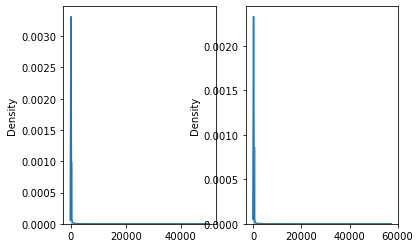

In [8]:
# 观察分布
from collections import Counter
fig, axis = plt.subplots(1, 2)
print(len(all_positive_words))
pos_words_freq = list(Counter(all_positive_words).values())
print(len(all_negative_words))
neg_words_freq = list(Counter(all_negative_words).values())
sns.distplot(pos_words_freq, ax = axis[0])
sns.distplot(neg_words_freq, ax = axis[1])
fig.show()

In [9]:
imdb_data["review"] = final_string

In [10]:
import copy
dic=copy.deepcopy(imdb_data)

In [11]:
# 改成数字格式
def conv_label(label):
    if label.lower() == "positive":
        return 1
    elif label.lower() == "negative":
        return 0

imdb_data["sentiment"] = imdb_data["sentiment"].map(conv_label)

In [12]:
imdb_data.head(10)

,review,sentiment
0,b'one review mention watch episod youll hook r...,1
1,b'wonder littl product film techniqu fashion g...,1
2,b'thought wonder way spend time hot summer wee...,1
3,b'basic there famili littl boy jake think ther...,0
4,b'petter mattei love time money visual stun fi...,1
5,b'probabl favorit movi stori selfless sacrific...,1
6,b'sure would like see resurrect date seahunt s...,1
7,b'show amaz fresh innov idea first air first y...,0
8,b'encourag posit comment film look forward wat...,0
9,b'like origin gut wrench laughter like movi yo...,1


In [13]:
dic

,review,sentiment
0,b'one review mention watch episod youll hook r...,positive
1,b'wonder littl product film techniqu fashion g...,positive
2,b'thought wonder way spend time hot summer wee...,positive
3,b'basic there famili littl boy jake think ther...,negative
4,b'petter mattei love time money visual stun fi...,positive
...,...,...
49995,b'thought movi right good job wasnt creativ or...,positive
49996,b'bad plot bad dialogu bad act idiot direct an...,negative
49997,b'cathol taught parochi elementari school nun ...,negative
49998,b'go disagre previous comment side maltin one ...,negative


In [14]:
# 计数法
count_vect = CountVectorizer(ngram_range = (1, 2))
count_vect = count_vect.fit(imdb_data["review"].values)
bigram_wrds = count_vect.transform(imdb_data["review"].values)

In [15]:
# TF-IDF法
count_vect_tfidf = TfidfVectorizer(ngram_range = (1, 2))
count_vect_tfidf = count_vect_tfidf.fit(imdb_data["review"].values)
tfidf_wrds  = count_vect_tfidf.transform(imdb_data["review"].values)

In [22]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y, y_pred, cmap=plt.cm.Blues, title='混淆矩阵'):
    """
    绘制混淆矩阵
    :param y: 真实值
    :param y_pred: 预测值
    :param cmap: 热力图的颜色
    :param title: 图像标题
    :return:
    """
    cm = confusion_matrix(y, y_pred)
    classes = list(set(y))
    classes.sort()
    plt.imshow(cm, cmap)
    indices = range(len(cm))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    # 热度表
    plt.colorbar()
    # 坐标轴含义
    plt.xlabel('guess')
    plt.ylabel('fact')
    plt.title(title)
    # 显示数据的值（Numbers）
    for first_index in range(len(cm)):
        for second_index in range(len(cm[first_index])):
            plt.text(first_index, second_index, cm[first_index][second_index])

计数法测试集准确率: 88.22
计数法训练集准确率 99.65428571428572
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      7411
           1       0.90      0.86      0.88      7589

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



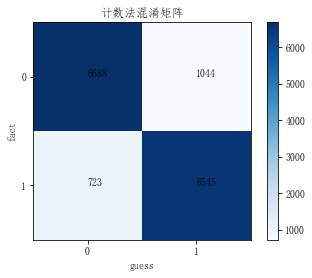

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from pylab import mpl

# change X to bigram_wrds to run classifier on Bag Of Words(BoW)
X = bigram_wrds
# X = tfidf_wrds
Y = imdb_data["sentiment"]
x_l, x_test, y_l, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.7)
clf.fit(x_l, y_l)
pred = clf.predict(x_test)
acc = accuracy_score(y_test, pred, normalize = True) * float(100)  
print("计数法测试集准确率:", acc)
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plot_confusion_matrix(y_test,
                          pred,
                          title='计数法混淆矩阵')
train_acc = accuracy_score(y_l, clf.predict(x_l), normalize = True) * float(100)
print("计数法训练集准确率", train_acc)
print(classification_report(y_test, pred))

TF-IDF测试集准确率: 88.62
TF-IDF训练集准确率: 98.86571428571429
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      7411
           1       0.91      0.87      0.88      7589

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



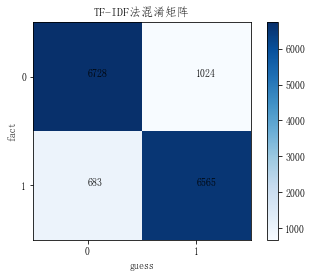

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
X = tfidf_wrds
Y = imdb_data["sentiment"]
x_l, x_test, y_l, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.7)
clf.fit(x_l, y_l)
pred = clf.predict(x_test)
acc = accuracy_score(y_test, pred, normalize = True) * float(100)  
print("TF-IDF测试集准确率:", acc)
plot_confusion_matrix(y_test,
                          pred,
                          title='TF-IDF法混淆矩阵')
train_acc = accuracy_score(y_l, clf.predict(x_l), normalize = True) * float(100)
print("TF-IDF训练集准确率:", train_acc)
print(classification_report(y_test, pred))

# ②使用 TD_IDF 实现新闻话题分类预测

In [25]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_20newsgroups # 引入新闻数据数据包
from sklearn.feature_extraction.text import TfidfVectorizer #做tfidf编码
from sklearn.feature_selection import SelectKBest, chi2 # 卡方检验——特征筛选
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [26]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [27]:
### 数据加载
print (u'开始下载/加载数据...')
t_start = time()
## 不要头部信息
remove = ('headers', 'footers', 'quotes')
## 只要这四类数据
categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'

## 分别加载训练数据和测试数据
data_train = fetch_20newsgroups(data_home='./data/',subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
data_test = fetch_20newsgroups(data_home='./data/',subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)

## 完成
print (u"完成数据加载过程.耗时:%.3fs" % (time() - t_start))

开始下载/加载数据...
完成数据加载过程.耗时:2.350s


In [28]:
### 获取加载数据的相关信息
# 算下docs大小
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

categories = data_train.target_names
data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(u'数据类型：', type(data_train))
print("%d文本数量 - %0.3fMB (训练数据集)" % (len(data_train.data), data_train_size_mb))
print("%d文本数量 - %0.3fMB (测试数据集)" % (len(data_test.data), data_test_size_mb))
print(u'训练集和测试集使用的%d个类别的名称：' % len(categories))
print(categories)

数据类型： <class 'sklearn.utils.Bunch'>
2034文本数量 - 2.428MB (训练数据集)
1353文本数量 - 1.800MB (测试数据集)
训练集和测试集使用的4个类别的名称：
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [29]:
### 数据重命名
x_train = data_train.data
y_train = data_train.target
x_test = data_test.data
y_test = data_test.target

In [30]:
### 输出前5个样本
print (u' -- 前5个文本 -- ')
for i in range(5):
    print (u'文本%d(属于类别 - %s)：' % (i+1, categories[y_train[i]]))
    print (x_train[i])
    print ('\n\n')

 -- 前5个文本 -- 
文本1(属于类别 - alt.atheism)：
If one is a vegan (a vegetarian taht eats no animal products at at i.e eggs, 
milk, cheese, etc., after about 3 years of a vegan diet, you need to start 
taking B12 supplements because b12 is found only in animals.) Acutally our 
bodies make B12, I think, but our bodies use up our own B12 after 2 or 3 
years.  
Lacto-oveo vegetarians, like myself, still get B12 through milk products 
and eggs, so we don't need supplements.
And If anyone knows more, PLEASE post it.  I'm nearly contridicting myself 
with the mish-mash of knowledge I've gleaned.



文本2(属于类别 - comp.graphics)：
Hi,
         I have a friend who is working on 2-d and 3-d object recognition. He is looking
for references describing algorithms on the following subject areas:

Thresholding
Edge Segmentation
Marr-Hildreth
Sobel Operator
Chain Codes
Thinning - Skeletonising

If anybody is willing to post an algorithm that they have implemented which demonstrates
any of the above topics, it woul

In [31]:
### 文档转换为向量
## 转换
## max_df 只取前50%的权重
vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
x_test = vectorizer.transform(data_test.data)
print (u'训练集样本个数：%d，特征个数：%d' % x_train.shape)
print (u'停止词:\n')
print(vectorizer.get_stop_words())
## 获取最终的特征属性名称
feature_names = np.asarray(vectorizer.get_feature_names())

训练集样本个数：2034，特征个数：26576
停止词:

frozenset({'whatever', 'go', 'toward', 'each', 'thick', 'whoever', 'rather', 'though', 'hereby', 'namely', 'done', 'give', 'seeming', 'anyway', 'one', 'much', 'are', 'thus', 'am', 'interest', 'herself', 'wherever', 'part', 'into', 'and', 'be', 'therefore', 'often', 'at', 'couldnt', 'latterly', 'that', 'otherwise', 'last', 'out', 'five', 'another', 'nobody', 'afterwards', 'thin', 'least', 'such', 'well', 'it', 'cry', 'mostly', 'onto', 'there', 'where', 'here', 'until', 'between', 'describe', 'becomes', 'me', 'formerly', 'few', 'somehow', 'their', 'name', 'take', 'detail', 'enough', 'sometimes', 'already', 'mill', 'con', 'several', 'off', 'to', 'once', 'had', 'itself', 'you', 'do', 'also', 'those', 'most', 'somewhere', 'becoming', 'even', 'us', 'cant', 'bill', 'down', 'after', 'when', 'all', 'whereas', 'beforehand', 'amount', 'with', 'about', 'thru', 'has', 'by', 'or', 'him', 'the', 'hereafter', 'wherein', 'have', 'thereafter', 'hasnt', 'her', 'himself', 'ev

In [32]:
## 特征选择
ch2 = SelectKBest(chi2, k=1000)
x_train = ch2.fit_transform(x_train, y_train)
x_test = ch2.transform(x_test)
feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

In [33]:
alpha_can = np.logspace(-2, 1, 10)
param_grid={'alpha': alpha_can}
cv=5
m = alpha_can.size


In [34]:
t_start = time()
mnb2=MultinomialNB()
mnb2.fit(x_train, y_train)

## 模型预测
t_start = time()
y_hat = mnb2.predict(x_test)
t_end = time()
t_test = t_end - t_start
print (u'测试时间：%.3f秒' % t_test)

## 模型效果评估
train_acc = metrics.accuracy_score(y_train, mnb2.predict(x_train))
test_acc = metrics.accuracy_score(y_test, y_hat)
print (u'训练集准确率：%.2f%%' % (100 * train_acc))
print (u'测试集准确率：%.2f%%' % (100 * test_acc))

测试时间：0.001秒
训练集准确率：85.94%
测试集准确率：73.84%


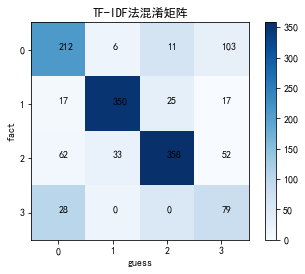

In [35]:
plot_confusion_matrix(y_test,
                          y_hat,
                          title='TF-IDF法混淆矩阵')